# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  

In [1]:
# Standard libraries
# import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch core
import torch
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
# from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.losses1 import PiCOLoss, UpperBoundWeakProperLoss
# from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
# dataset_name = 'Cifar10'
dataset_name = 'mnist'
Data = Data_handling(
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42,
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y

print(f"Number of classes: {Data.num_classes}")
print(f"Array of targets: \n {Data.test_dataset.targets}")
df = pd.DataFrame(
    Data.train_dataset.data.numpy(),
    # columns=[f'feature_{i}' 
    columns=[f'x_{i}' 
             for i in range(Data.train_dataset.data.shape[1])])

# Add target column
df['target'] = [i for i in Data.train_dataset.targets.numpy()]

# Print 3 rows
print(df.head(3))

Number of classes: 10
Array of targets: 
 tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
   x_0  x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  x_9  ...  x_775  x_776  x_777  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   x_778  x_779  x_780  x_781  x_782  x_783  \
0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0   

                                              target  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 1

Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [4]:
# Generate transition matrix M
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) # For noisy labels
print(f"Generated M matrix:\n"
      f"{np.array2string(weakener.M, precision=4, suppress_small=True)}")

# Generate weak labels z
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)
z = weakener.generate_weak(
    true_onehot, compute_w=True, compute_Y=False, compute_Y_opt=False,
    compute_Y_conv=False, compute_Y_opt_conv=False)
print(f"Generated weak labels z:\n{z}")

# Compute virtual labels
print("Computing virtual labels...")
# Since z[i] is an integer, row i must contain the z[i]-th row of weakener.Z
virtual_labels = weakener.Z[z]

# Add weak and virtual labels to the dataset
Data.include_weak(z)
Data.include_virtual(virtual_labels, initial_weight=1/Data.num_classes)

# Get dataloaders with weak labels and indices
train_loader, test_loader = Data.get_dataloader(
    weak_labels='all', get_index=True)

Generated M matrix:
[[0.     0.     0.     ... 0.     0.     0.1342]
 [0.     0.     0.     ... 0.     0.1342 0.    ]
 [0.     0.     0.     ... 0.     0.0336 0.0336]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]
Generated weak labels z:
tensor([144, 648, 176,  ...,  17,  23,  18], dtype=torch.int32)
Computing virtual labels...


In [5]:
batch = next(iter(train_loader))
xb, wb, vb, cb, yb, ib = batch
print(f"Inputs batch: shape {xb.shape}")
print(f"Weak (partial) labels: shape {wb.shape}, first row: {wb[0]}")
print(f"Virtual labels: shape {vb.shape}, first row: {vb[0]}")
print(f"Weights: shape {cb.shape}, first row: {cb[0]}")
print(f"True one-hot labels shape: {yb.shape}, first row: {yb[0]}")
print(f"Indices batch: shape {ib.shape}, first row: {ib[0]}")

Inputs batch: shape torch.Size([64, 784])
Weak (partial) labels: shape torch.Size([64]), first row: 144
Virtual labels: shape torch.Size([64, 10]), first row: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1])
Weights: shape torch.Size([64, 10]), first row: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
True one-hot labels shape: torch.Size([64, 10]), first row: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Indices batch: shape torch.Size([64]), first row: 0


In [6]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'x_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]




1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

In [7]:
# ##########################
# Define model and optimizer
def get_model(Data, opt_alg='adam', lr=1e-6, momentum=0.9):
    """ Define model and optimizer
    Parameters
        Data: dataset object with num_classes and num_features attributes
    Returns
        model: the neural network model
        optimizer: the optimizer
    """

    model = MLP(
        input_size=Data.num_features,
        hidden_sizes=[],
        output_size=Data.num_classes,
        dropout_p=0,
        bn=False,
        activation='relu')

    if opt_alg == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt_alg == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_alg}") 

    return model, optimizer

# ########################
# Visualization of results
def plot_results(results_df):
    """ Plot training results
    Parameters
        results_df: DataFrame with training results
    """

    # Set up a wide figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Loss curves
    ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
    ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

Now we define a method with the steps of each simulation to test a learning algorithm

In [8]:
def run_simulation(Data, loss, num_epochs=10, optimizer_name='adam', 
                   loss_code=None, pseudolabel_model=None, lr=1e-6, corr_p=0.2,
                   phi=0.8):
    """Run a training simulation with the specified parameters.

    Parameters
    ----------
    Data : dataset object
        The dataset object containing training and test data.
    loss : loss function object
        The loss function to use for training.
    num_epochs : int, optional
        The number of training epochs (default is 10).
    optimizer_name : str, optional
        The name of the optimizer to use (default is 'adam').
    loss_code : str, optional
        A code representing the loss function (for metadata) (default is None).
    pseudolabel_model : str, optional
        A string indicating the pseudolabel model used (for metadata)
        (default is None).
    lr : float, optional
        The learning rate for the optimizer (default is 1e-6).
    corr_p : float, optional
        The corruption probability used in the weak label generation 
        (for metadata) (default is 0.2).
    phi : float, optional
        The phi parameter for the training loop (default is 0.8).
    """

    # 1. Get model and optimizer
    model, optimizer = get_model(Data, opt_alg=optimizer_name, lr=lr)

    # 2. Run the training + evaluation loop
    model, results_df = train_and_evaluate(
        model, train_loader, test_loader, optimizer, loss, num_epochs,
        phi=phi, pseudolabel_model=pseudolabel_model)

    # 3. Save simultation attributes in a metadata dictionary
    metadata = {'pseudo_label_model': pseudolabel_model, 'loss_name': loss_code, 
                'corr_p': corr_p, 'optimizer': type(optimizer).__name__,
                'initial_lr': optimizer.param_groups[0]['lr'], 'phi': phi}
    print(pd.DataFrame([metadata]).T)

    # 4. View the epoch‐by‐epoch results
    plot_results(results_df)

    return model, optimizer, metadata, results_df

In [9]:
# #####################################
# Common parameters for all simulations

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training parameters
num_epochs = 10
optimizer_name = 'adam'
lr = 1e-6

Using device: cpu


## Running experiments  

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 0.0036, Train Acc: 0.9095, Test Acc: 0.9159, Train Detached Loss: 0.0050, Test Detached Loss: 0.0048, Learning Rate: 0.000001, Epoch Time: 1.63 seconds
                                0
pseudo_label_model           PiCO
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr               0.000001
phi                           0.8


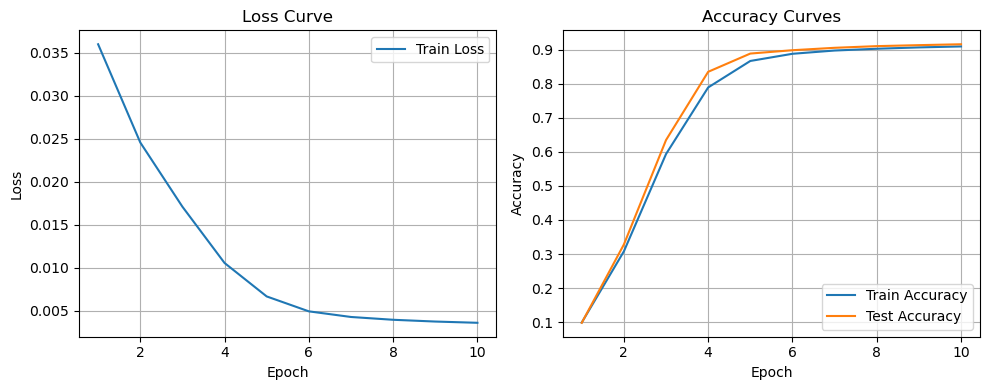

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,PiCO,0.035997,0.098717,0.0980,0.035997,0.036151,0.000001,1.715254
1,2,PiCO,0.024586,0.307833,0.3280,0.027917,0.028016,0.000001,1.582165
2,3,PiCO,0.017119,0.593500,0.6346,0.016173,0.016031,0.000001,1.556849
3,4,PiCO,0.010579,0.789117,0.8350,0.009412,0.009144,0.000001,1.625606
4,5,PiCO,0.006691,0.866850,0.8886,0.006713,0.006436,0.000001,1.661839
5,6,PiCO,0.004957,0.887917,0.8984,0.005874,0.005637,0.000001,1.484115
6,7,PiCO,0.004303,0.897500,0.9055,0.005494,0.005280,0.000001,1.522291
7,8,PiCO,0.003978,0.902733,0.9104,0.005247,0.005050,0.000001,1.493085
8,9,PiCO,0.003772,0.906650,0.9133,0.005083,0.004901,0.000001,1.633539
9,10,PiCO,0.003627,0.909483,0.9159,0.004962,0.004796,0.000001,1.631198


In [10]:
# #################
# Testing PiCO Loss

loss_code = "cross_entropy"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 0.0735, Train Acc: 0.9172, Test Acc: 0.9215, Train Detached Loss: 0.0046, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 1.31 seconds
                                0
pseudo_label_model             MC
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr               0.000001
phi                           0.8


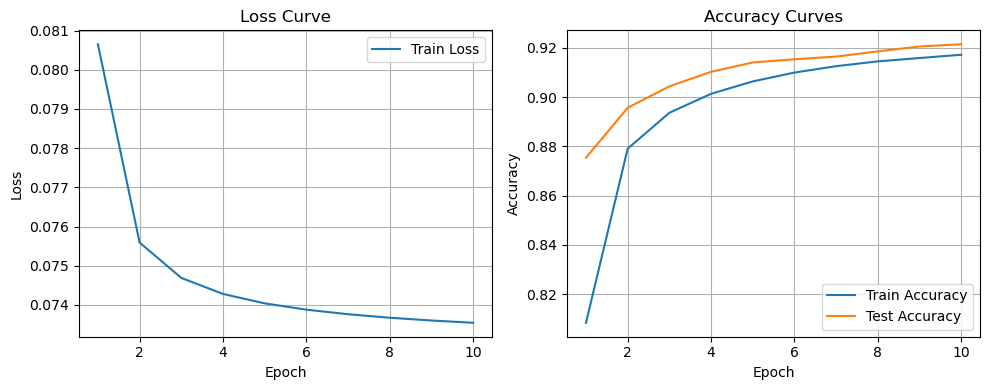

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MC,0.080649,0.808367,0.8754,0.008663,0.008332,0.000001,1.381418
1,2,MC,0.075591,0.879100,0.8957,0.006607,0.006325,0.000001,1.431299
2,3,MC,0.074689,0.893667,0.9044,0.005850,0.005606,0.000001,1.326994
3,4,MC,0.074280,0.901383,0.9103,0.005445,0.005232,0.000001,1.289269
4,5,MC,0.074040,0.906400,0.9141,0.005191,0.005003,0.000001,1.292898
5,6,MC,0.073879,0.910000,0.9154,0.005015,0.004849,0.000001,1.336402
6,7,MC,0.073763,0.912600,0.9165,0.004885,0.004739,0.000001,1.437706
7,8,MC,0.073674,0.914550,0.9186,0.004785,0.004656,0.000001,1.308654
8,9,MC,0.073603,0.915917,0.9206,0.004705,0.004593,0.000001,1.349538
9,10,MC,0.073544,0.917233,0.9215,0.004640,0.004543,0.000001,1.305025


In [11]:
# #################
# Marginal Chain

loss_code = "cross_entropy"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 0.0735, Train Acc: 0.9173, Test Acc: 0.9215, Train Detached Loss: 0.0046, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 1.50 seconds
                                0
pseudo_label_model            FWD
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr               0.000001
phi                           0.8


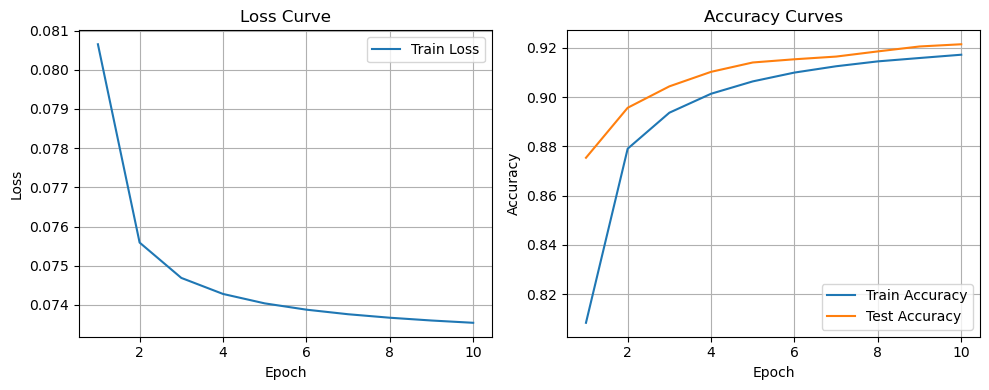

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,FWD,0.080649,0.808367,0.8754,0.008663,0.008332,0.000001,1.489299
1,2,FWD,0.075591,0.879083,0.8957,0.006607,0.006325,0.000001,1.415356
2,3,FWD,0.074689,0.893700,0.9044,0.005850,0.005606,0.000001,1.360548
3,4,FWD,0.074280,0.901400,0.9103,0.005445,0.005232,0.000001,1.354481
4,5,FWD,0.074040,0.906417,0.9141,0.005191,0.005003,0.000001,1.347451
5,6,FWD,0.073879,0.910000,0.9154,0.005015,0.004849,0.000001,1.374399
6,7,FWD,0.073763,0.912567,0.9165,0.004885,0.004739,0.000001,1.315436
7,8,FWD,0.073674,0.914550,0.9186,0.004785,0.004656,0.000001,1.330861
8,9,FWD,0.073603,0.915917,0.9206,0.004705,0.004593,0.000001,1.344595
9,10,FWD,0.073544,0.917250,0.9215,0.004640,0.004543,0.000001,1.501916


In [12]:
# #################
# Forward Proper Loss

loss_code = "cross_entropy"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 0.0047, Train Acc: 0.9172, Test Acc: 0.9215, Train Detached Loss: 0.0046, Test Detached Loss: 0.0045, Learning Rate: 0.000001, Epoch Time: 1.63 seconds
                                0
pseudo_label_model             MM
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr               0.000001
phi                           0.8


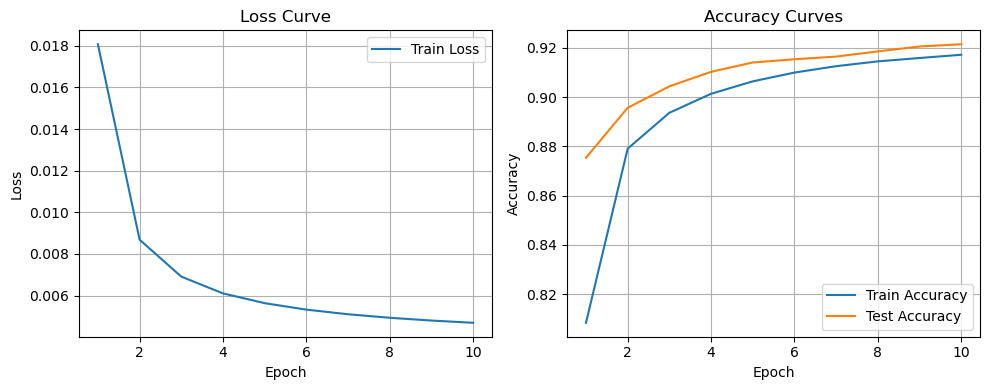

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MM,0.018077,0.808367,0.8754,0.008663,0.008332,0.000001,1.522332
1,2,MM,0.008683,0.879100,0.8957,0.006607,0.006325,0.000001,1.620808
2,3,MM,0.006907,0.893667,0.9044,0.005850,0.005606,0.000001,1.407122
3,4,MM,0.006102,0.901383,0.9103,0.005445,0.005232,0.000001,1.472304
4,5,MM,0.005632,0.906433,0.9141,0.005191,0.005003,0.000001,1.566699
5,6,MM,0.005321,0.910000,0.9154,0.005015,0.004849,0.000001,1.561558
6,7,MM,0.005099,0.912600,0.9165,0.004885,0.004739,0.000001,1.571554
7,8,MM,0.004930,0.914550,0.9186,0.004785,0.004656,0.000001,1.366957
8,9,MM,0.004797,0.915917,0.9206,0.004705,0.004593,0.000001,1.496226
9,10,MM,0.004689,0.917233,0.9215,0.004640,0.004543,0.000001,1.634302


In [13]:
# ############
# Majorization-Minimization (Uppder bound)

loss_code = "cross_entropy"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: -0.0046, Train Acc: 0.4967, Test Acc: 0.4964, Train Detached Loss: 0.1462, Test Detached Loss: 0.1503, Learning Rate: 0.000001, Epoch Time: 1.38 seconds
                           0
pseudo_label_model        MC
loss_name               ps_2
corr_p                   0.2
optimizer               Adam
initial_lr          0.000001
phi                      0.8


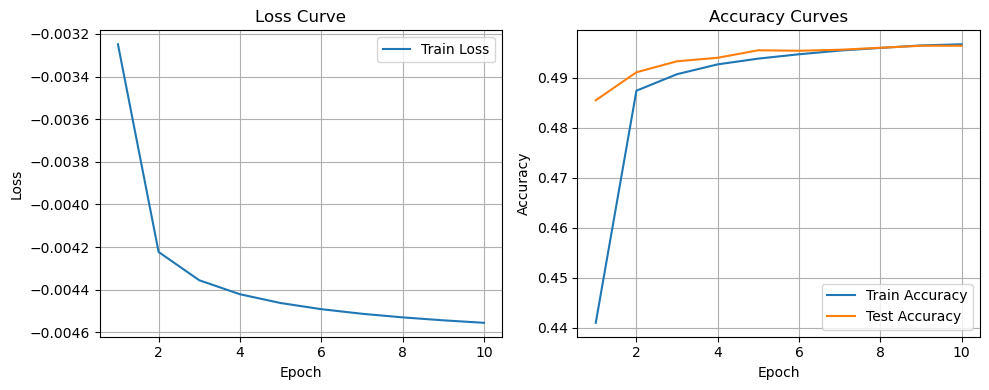

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MC,-0.003248,0.441000,0.4855,0.070820,0.072622,0.000001,1.690814
1,2,MC,-0.004223,0.487417,0.4911,0.085659,0.087975,0.000001,1.548376
2,3,MC,-0.004355,0.490717,0.4933,0.095852,0.098498,0.000001,1.613749
3,4,MC,-0.004421,0.492683,0.4940,0.104321,0.107229,0.000001,1.797762
4,5,MC,-0.004462,0.493833,0.4955,0.111935,0.115070,0.000001,1.654114
5,6,MC,-0.004491,0.494700,0.4954,0.119053,0.122393,0.000001,1.368794
6,7,MC,-0.004513,0.495433,0.4956,0.125912,0.129445,0.000001,1.415462
7,8,MC,-0.004530,0.495967,0.4960,0.132657,0.136375,0.000001,1.386228
8,9,MC,-0.004543,0.496467,0.4964,0.139390,0.143289,0.000001,1.386703
9,10,MC,-0.004555,0.496700,0.4964,0.146177,0.150256,0.000001,1.375095


In [14]:
# #################
# Marginal Chain

loss_code = "ps_2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: -0.0001, Train Acc: 0.6784, Test Acc: 0.6812, Train Detached Loss: 0.0673, Test Detached Loss: 0.0692, Learning Rate: 0.000001, Epoch Time: 2.36 seconds
                           0
pseudo_label_model       FWD
loss_name               ps_2
corr_p                   0.2
optimizer               Adam
initial_lr          0.000001
phi                      0.8


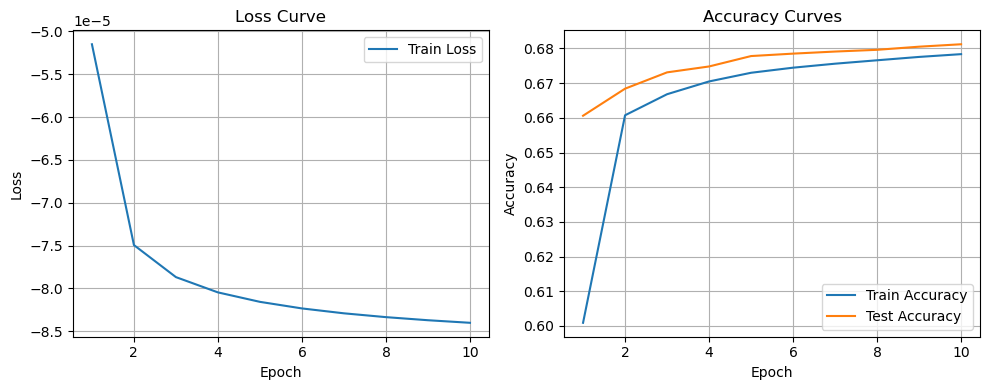

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,FWD,-0.000051,0.600917,0.6606,0.034283,0.034901,0.000001,1.840698
1,2,FWD,-0.000075,0.660733,0.6684,0.040435,0.041310,0.000001,1.761996
2,3,FWD,-0.000079,0.666800,0.6731,0.044749,0.045806,0.000001,1.716330
3,4,FWD,-0.000080,0.670483,0.6748,0.048361,0.049572,0.000001,2.171802
4,5,FWD,-0.000082,0.672983,0.6778,0.051651,0.053000,0.000001,2.406730
5,6,FWD,-0.000082,0.674450,0.6785,0.054794,0.056269,0.000001,2.063829
6,7,FWD,-0.000083,0.675600,0.6791,0.057881,0.059477,0.000001,2.748100
7,8,FWD,-0.000083,0.676583,0.6796,0.060970,0.062686,0.000001,2.601985
8,9,FWD,-0.000084,0.677550,0.6805,0.064093,0.065932,0.000001,2.319321
9,10,FWD,-0.000084,0.678350,0.6812,0.067262,0.069224,0.000001,2.358294


In [15]:
loss_code = "ps_2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: -0.0046, Train Acc: 0.4967, Test Acc: 0.4964, Train Detached Loss: 0.1462, Test Detached Loss: 0.1503, Learning Rate: 0.000001, Epoch Time: 1.55 seconds
                           0
pseudo_label_model        MM
loss_name               ps_2
corr_p                   0.2
optimizer               Adam
initial_lr          0.000001
phi                      0.8


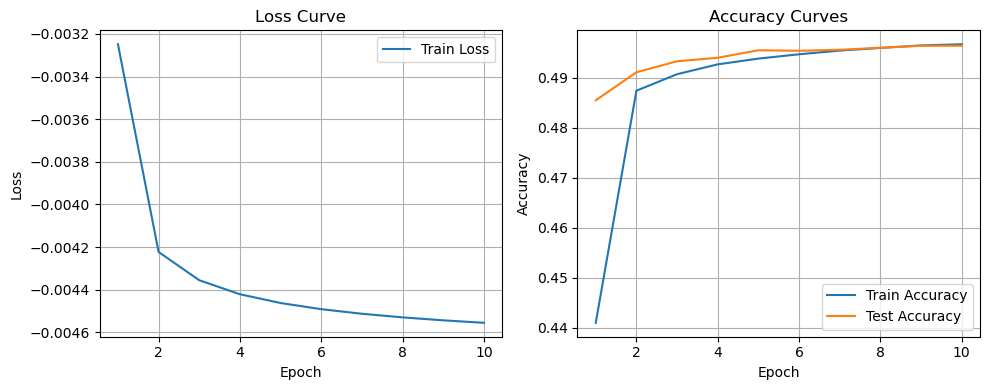

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MM,-0.003248,0.441017,0.4855,0.070820,0.072621,0.000001,1.571034
1,2,MM,-0.004223,0.487417,0.4911,0.085659,0.087975,0.000001,1.809353
2,3,MM,-0.004355,0.490717,0.4933,0.095852,0.098498,0.000001,1.783543
3,4,MM,-0.004421,0.492683,0.4940,0.104321,0.107229,0.000001,1.721985
4,5,MM,-0.004462,0.493833,0.4955,0.111935,0.115070,0.000001,1.567839
5,6,MM,-0.004491,0.494700,0.4954,0.119053,0.122393,0.000001,1.555569
6,7,MM,-0.004513,0.495433,0.4956,0.125912,0.129445,0.000001,1.469360
7,8,MM,-0.004530,0.495967,0.4960,0.132657,0.136375,0.000001,1.457986
8,9,MM,-0.004543,0.496467,0.4964,0.139390,0.143289,0.000001,1.605349
9,10,MM,-0.004555,0.496700,0.4964,0.146176,0.150256,0.000001,1.550541


In [16]:
loss_code = "ps_2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 0.0389, Train Acc: 0.8715, Test Acc: 0.8792, Train Detached Loss: 0.0061, Test Detached Loss: 0.0060, Learning Rate: 0.000001, Epoch Time: 1.44 seconds
                              0
pseudo_label_model           MC
loss_name           tsallis_0.2
corr_p                      0.2
optimizer                  Adam
initial_lr             0.000001
phi                         0.8


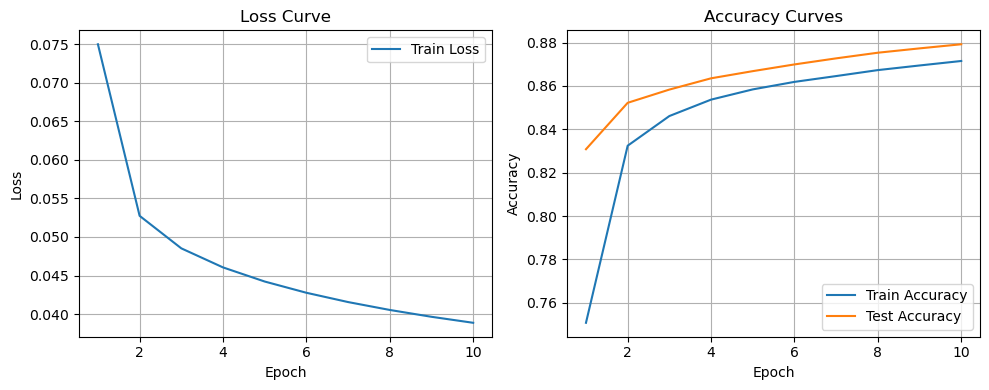

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MC,0.074983,0.750750,0.8308,0.008741,0.008406,0.000001,1.484103
1,2,MC,0.052744,0.832417,0.8522,0.007631,0.007331,0.000001,1.686724
2,3,MC,0.048528,0.846100,0.8583,0.007181,0.006907,0.000001,1.636057
3,4,MC,0.046058,0.853667,0.8635,0.006892,0.006641,0.000001,1.706892
4,5,MC,0.044228,0.858383,0.8668,0.006682,0.006452,0.000001,1.852006
5,6,MC,0.042771,0.861850,0.8699,0.006519,0.006307,0.000001,1.521738
6,7,MC,0.041566,0.864533,0.8727,0.006385,0.006192,0.000001,1.535698
7,8,MC,0.040543,0.867283,0.8753,0.006275,0.006099,0.000001,1.625702
8,9,MC,0.039656,0.869417,0.8773,0.006181,0.006022,0.000001,1.417998
9,10,MC,0.038878,0.871483,0.8792,0.006100,0.005958,0.000001,1.439049


In [17]:
# ##############
# Marginal Chain

loss_code = "tsallis_0.2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 3.0692, Train Acc: 0.8782, Test Acc: 0.8840, Train Detached Loss: 0.0061, Test Detached Loss: 0.0060, Learning Rate: 0.000001, Epoch Time: 2.73 seconds
                              0
pseudo_label_model          FWD
loss_name           tsallis_0.2
corr_p                      0.2
optimizer                  Adam
initial_lr             0.000001
phi                         0.8


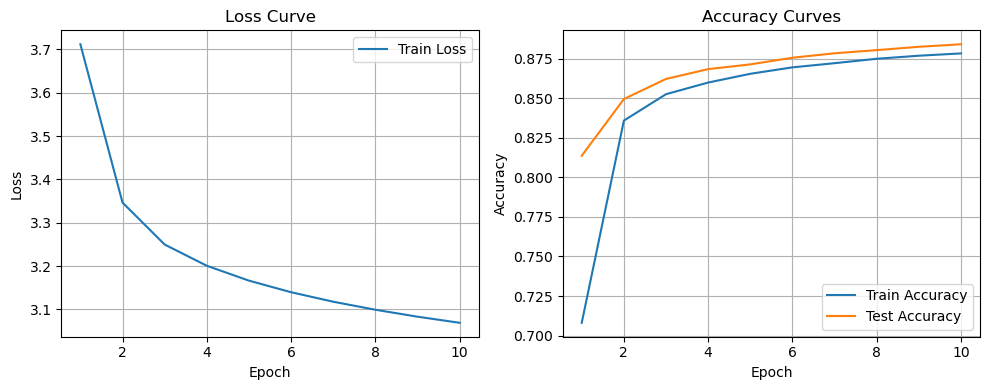

In [18]:
loss_code = "tsallis_0.2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 0.0388, Train Acc: 0.8716, Test Acc: 0.8793, Train Detached Loss: 0.0061, Test Detached Loss: 0.0060, Learning Rate: 0.000001, Epoch Time: 1.44 seconds
                              0
pseudo_label_model           MM
loss_name           tsallis_0.2
corr_p                      0.2
optimizer                  Adam
initial_lr             0.000001
phi                         0.8


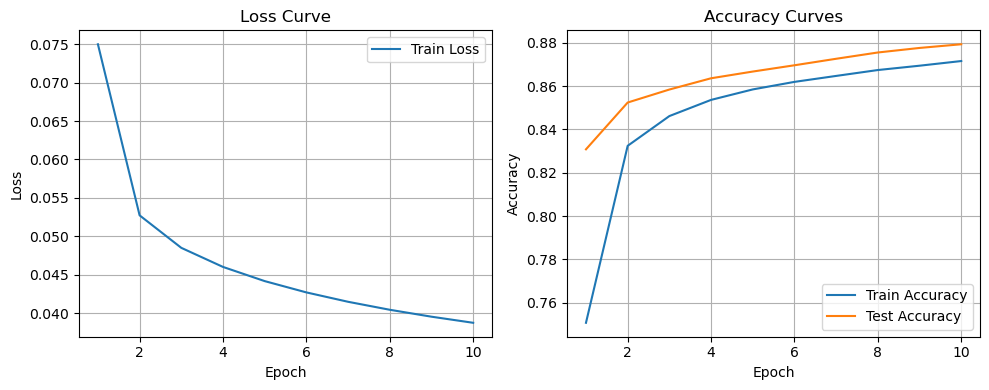

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,MM,0.074983,0.750717,0.8308,0.008741,0.008406,0.000001,1.442045
1,2,MM,0.052737,0.832417,0.8524,0.007631,0.007331,0.000001,1.432122
2,3,MM,0.048512,0.846150,0.8584,0.007180,0.006907,0.000001,1.437055
3,4,MM,0.046030,0.853617,0.8636,0.006892,0.006641,0.000001,1.486769
4,5,MM,0.044187,0.858450,0.8667,0.006682,0.006451,0.000001,1.487999
5,6,MM,0.042717,0.861933,0.8696,0.006518,0.006307,0.000001,1.476509
6,7,MM,0.041498,0.864683,0.8726,0.006384,0.006192,0.000001,1.466599
7,8,MM,0.040460,0.867400,0.8755,0.006273,0.006099,0.000001,1.443492
8,9,MM,0.039560,0.869400,0.8776,0.006179,0.006021,0.000001,1.502146
9,10,MM,0.038767,0.871550,0.8793,0.006098,0.005957,0.000001,1.444325


In [19]:
loss_code = "tsallis_0.2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)